# Run (with wandb)

In [14]:
from run.run import RunSynthetic
config = dict(
    src_len=96,
    tgt_len=24,
    embedding_dim=16,
    nhead=4,
    num_layers=(2, 2),
    ts_embed='conv',
    pos_embed='fixed',
    batch_size=64,
    lr=1e-3,
    betas=(0.9, 0.98),
    sch_stepsize=5,
    sch_gamma=0.5,
    es_patience=5,
    n_epoch=50,
)
synth = RunSynthetic('demo', config, verbose=0, checkpoint_path='_checkpoints/synth_checkpoint.pth')

Start training
Finish training


epoch,29
train_loss,1.80463
train_metric,3.23992
val_loss,1.60006
val_metric,2.59653
_runtime,65
_timestamp,1627188234
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_metric,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_metric,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


# Infer

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm

from model.model import Transformer_fcst
from tools.infer import InferShortTerm, InferLongTerm
from tools.create_synthetic import create_multi
from tools.preprocess import make_input_target, make_src_tgt
from tools.train import make_loader

In [17]:
# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# model
src_len, tgt_len = 96, 24
model = Transformer_fcst(fcst_mode='gauss',
                         seq_len=(src_len, tgt_len),
                         embedding_dim=16,
                         nhead=4,
                         num_layers=(2, 2),
                         device=device,
                         ts_embed='conv',
                         pos_embed='fixed').to(device)
model.load_state_dict(torch.load('_model_pkls/synth_checkpoint.pth'))

# test data
test_data = create_multi(1000, src_len, tgt_len)
input, target = make_input_target(test_data, src_len, tgt_len)
test_dloader = make_loader(input, target, batch_size=64)

## Short-term forecasting (i.e. rolling-timestep forecast)

In [18]:
infershort = InferShortTerm(model)

### Eval

In [19]:
running_loss, running_metric = 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in test_dloader:
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, src_len, tgt_len)
        loss, metric = infershort.eval((src,tgt), target_batch)

        running_loss += loss.item()
        running_metric += metric.item()

print('Test loss:', running_loss / len(test_dloader))
print('Test metric:', running_metric / len(test_dloader))

Test loss: 1.5924751162528992
Test metric: 2.5638481825590134


### Plot samples

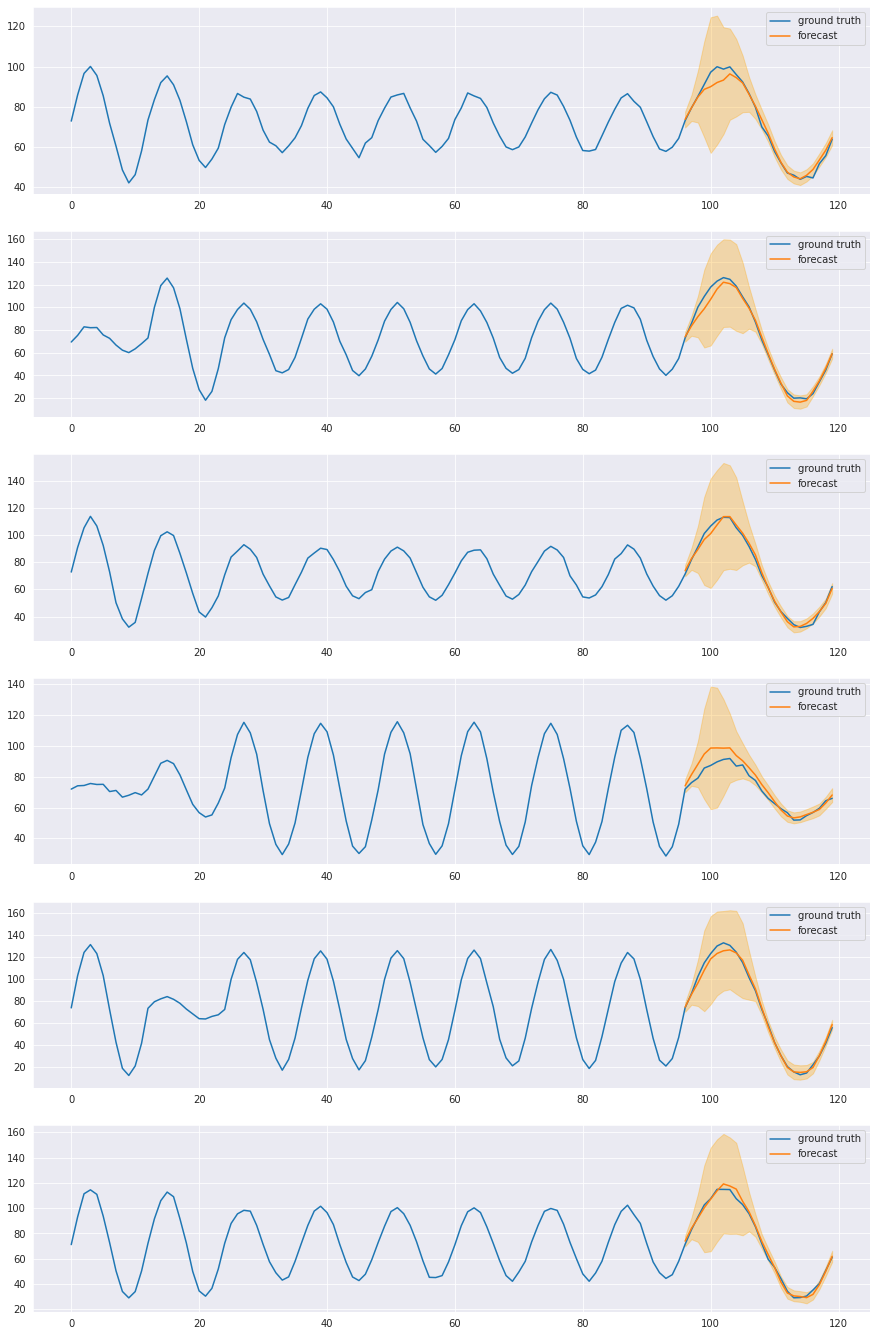

In [20]:
# canvas
fig, axes = plt.subplots(6,1, figsize=(15,24))

# sampling
sample_idxs = np.random.choice(input.shape[0], len(axes), replace=False)
input_sample, target_sample = input[sample_idxs], target[sample_idxs]

src, tgt = make_src_tgt(input_sample, src_len, tgt_len)

# plot
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    infershort.plot((src,tgt), target_sample, axes)

## Long-term forecasting (i.e. with recurrence)
> The code is identical to short-term forecasting. Only difference is to use InferLongTerm instead of InferShortTerm.

In [21]:
inferlong = InferLongTerm(model)

### Eval

In [22]:
running_loss, running_metric = 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in tqdm(test_dloader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, src_len, tgt_len)
        loss, metric = inferlong.eval((src, tgt), target_batch)
        
        running_loss += loss.item()
        running_metric += metric.item()

print('Test loss:', running_loss / len(test_dloader))
print('Test metric:', running_metric / len(test_dloader))


100%|██████████| 16/16 [00:24<00:00,  1.53s/it]

Test loss: 17.11753112077713
Test metric: 14.27282577753067


### Plot samples

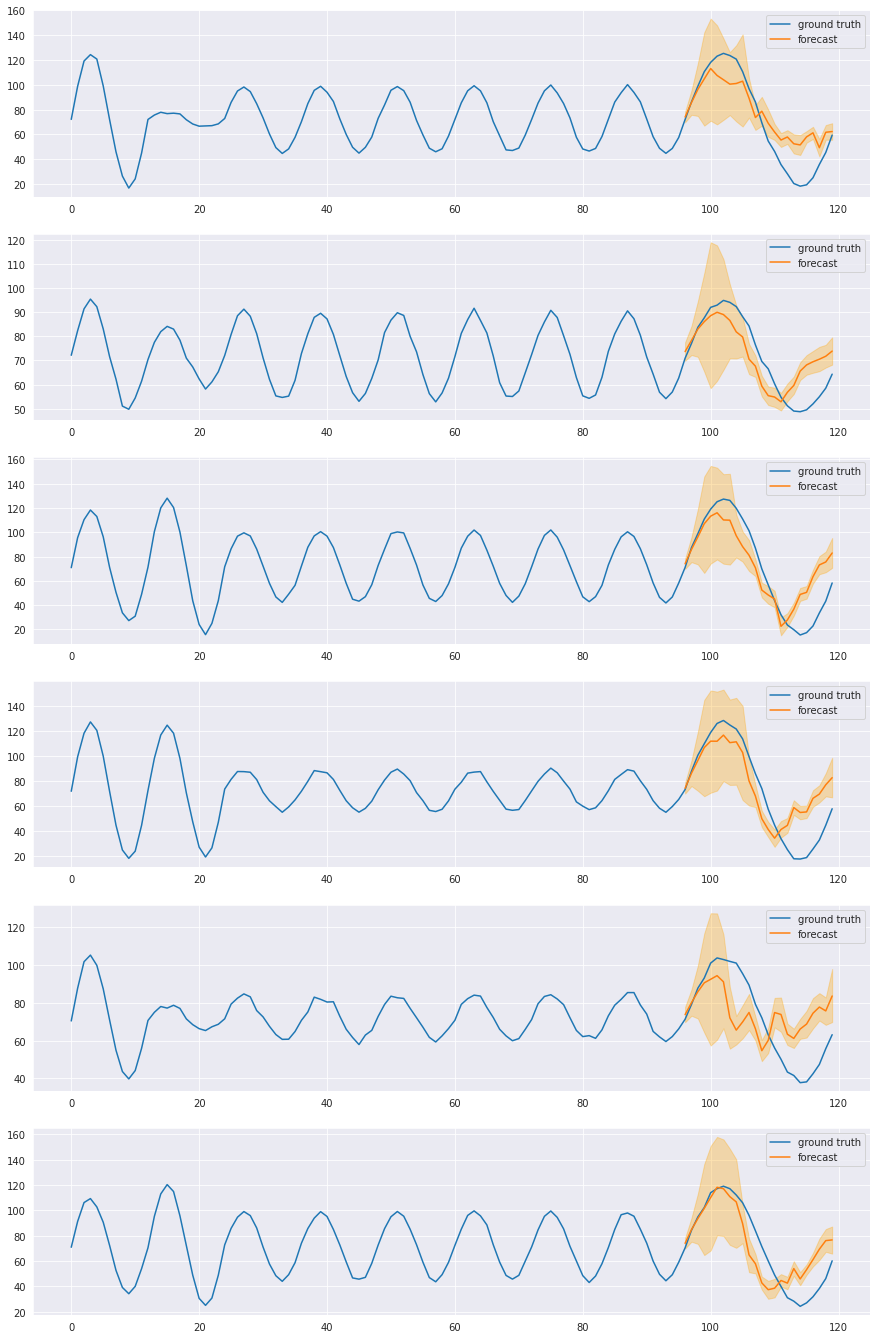

In [23]:
# canvas
fig, axes = plt.subplots(6, 1, figsize=(15, 24))

# sampling
sample_idxs = np.random.choice(input.shape[0], len(axes), replace=False)
input_sample, target_sample = input[sample_idxs], target[sample_idxs]

src, tgt = make_src_tgt(input_sample, src_len, tgt_len)

# plot
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    inferlong.plot((src, tgt), target_sample, axes)
    